In [16]:
import sys
sys.path.append('../src')
import time
import pickle
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from liab.k_leg_liab import k_leg_liab
from liab.shapley_liab import shapley_liab
from liab.random_system import get_rand_system, rerand_system, get_rand_float_vec, get_rand_failure
from liab.failure import ClosedHalfSpaceFailureSet
from IPython.display import display, clear_output
from multiprocessing import Pool
from scipy.stats import mannwhitneyu


SEED = 42
NUM_WORKERS = 7
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
S = get_rand_system(6, 'linear', seed=SEED)
T = rerand_system(S, seed=SEED+1)
print(S)
print(T)
print(S.func_type, T.func_type)

System(cs=[ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-25.09*x_0), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_3)])
System(cs=[ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-76.99*x_0), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-76.99*x_1+21.81*x_3)])
linear linear


In [3]:
M = S.induced_scm()
N = T.induced_scm()
print(M)
print(N)
print(M.func_type, N.func_type)

SCM(U={'x_0', 'x_1'}, V={'x_2', 'x_5', 'x_4', 'x_3'}, cs={'x_2': ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-25.09*x_0), 'x_3': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), 'x_4': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), 'x_5': ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_3)}, state_order=['x_2', 'x_3', 'x_4', 'x_5'])
SCM(U={'x_0', 'x_1'}, V={'x_2', 'x_5', 'x_4', 'x_3'}, cs={'x_2': ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-76.99*x_0), 'x_3': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), 'x_4': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), 'x_5': ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-76.99*x_1+21.81*x_3)}, state_order=['x_2', 'x_3', 'x_4', 'x_5'])
linear linear


In [75]:
def get_exp_unit(args):
    num_vars, seed = args
    rnd = np.random.RandomState(seed)
    while True:
        S = get_rand_system(num_vars, 'linear', rnd=rnd)
        T = rerand_system(S, rnd=rnd)
        M = S.induced_scm()
        N = T.induced_scm()
        F = get_rand_failure(list(M.V)[:2], ClosedHalfSpaceFailureSet, rnd=rnd)
        u = F.get_example_context(M, N, seed=seed)
        if u:
            state_m, _ = M.get_state(u)
            state_n, _ = N.get_state(u)
            if not F.contains(state_m) and F.contains(state_n):
                return T, S, u, F
            
def do_exp(args):
    T, S, u, F, ks = args
    k_leg_values, shapley_values, k_leg_times, shapley_times = {}, {}, {}, {}
    start_time = time.time()
    shapley = shapley_liab(T, S, u, F, k=-1)
    shapley_time = time.time() - start_time + 10
    for k in ks:
        start_time = time.time()
        k_leg = k_leg_liab(T, S, u, F, k=k)
        k_leg_times[k] = time.time() - start_time
        shapley_times[k] = shapley_time
        k_leg_values[k], shapley_values[k] = [], []
        for var in k_leg:
            k_leg_values[k].append(k_leg[var])
            if var in shapley:
                shapley_values[k].append(shapley[var])
            else:
                print(f'Warning: {var} not found in Shapley liability')

    return {'k_leg_values': k_leg_values, 'shapley_values': shapley_values,
        'k_leg_times': k_leg_times, 'shapley_times': shapley_times}

def experiment(num_vars, ks=[1,2], num_samples=20):
    print(f'Doing experiments ({num_samples=}) ...')
    units = []
    pbar = tqdm(total=num_samples)
    def update_progress_get_unit(unit):
        if unit:
            units.append(unit)
            pbar.update(1)
    def error_get_unit(e):
        raise e
    with Pool(NUM_WORKERS) as pool:
        tasks = [(num_vars, i) for i in range(num_samples)]
        for task in tasks:
            pool.apply_async(get_exp_unit, args=(task,), callback=update_progress_get_unit, error_callback=error_get_unit)
        pool.close()
        pool.join()
    pbar.close()
    
    print(f'Processing results for k in {ks} ...')
    exp_results = {'k_leg_values':  defaultdict(list), 'shapley_values':  defaultdict(list),
        'k_leg_times': defaultdict(list), 'shapley_times': defaultdict(list)}
    pbar = tqdm(total=num_samples)
    def update_progress_do_exp(exp_result):
        if exp_result:
            for k in ks:
                for key in exp_result:
                    exp_results[key][k].append(exp_result[key][k])
            pbar.update(1)
    def error_do_exp(e):
        raise e
    with Pool(NUM_WORKERS) as pool:
        tasks = []
        for unit in tqdm(units):
            T, S, u, F = unit
            tasks.append((T, S, u, F, ks))
        for task in tasks:
            pool.apply_async(do_exp, args=(task,), callback=update_progress_do_exp, error_callback=error_do_exp)
        pool.close()
        pool.join()
    pbar.close()
    
    return exp_results

def get_vargha_delaney(n1, n2, U):
    # Calculate Vargha and Delaney A effect size
    A = U / (n1 * n2)
    print(A)

    # Determine the effect size description
    if A >= 0.71 or A == 0:
        return f"large effect"
    elif A >= 0.64:
        return f"medium effect"
    elif A >= 0.56:
        return f"small effect"
    elif A >= 0.44:
        return f"negligible effect"
    else:
        return f"no effect"

def experiment_and_plot(num_vars, ks=[1,2], num_samples=20, exp_results=None):
    if exp_results is None:
        exp_results = experiment(num_vars, ks=ks, num_samples=num_samples)
        with open(f'{num_vars=}_{ks=}.pickle', 'wb') as pickle_fd:
            pickle.dump(exp_results, pickle_fd)
    
    k_leg_values, shapley_values, k_leg_times, shapley_times = tuple(exp_results.values())
    
    k_leg_flattened, shapley_falttened = defaultdict(list), defaultdict(list)
    for k in ks:
        for sublist in k_leg_values[k]:
            k_leg_flattened[k].extend(sublist)
        for sublist in shapley_values[k]:
            shapley_falttened[k].extend(sublist)

    # k_leg_mean, shapley_mean = defaultdict(list), defaultdict(list)
    # for k in ks:
    #     k_leg_mean[k] = np.array(k_leg_values[k]).mean()
    #     shapley_mean[k] = np.array(k_leg_values[k]).mean()

    fig, ax = plt.subplots(1, len(k_leg_times), figsize=(4*len(k_leg_times), 4))
    for ki, k in enumerate(k_leg_times):
        ax[ki].hist(k_leg_flattened[k], bins=20, alpha=0.7, label=f'{k}-leg')
        ax[ki].hist(shapley_falttened[k], bins=20, alpha=0.7, label=f'Shapley')
        ax[ki].legend()
        U, p_value = mannwhitneyu(k_leg_flattened[k], shapley_falttened[k], alternative='two-sided')
        effect_size = get_vargha_delaney(len(k_leg_flattened[k]), len(shapley_falttened[k]), U)
        ax[ki].set_title(f'p-vale={p_value:.3f}, effect={effect_size}')
        ax[ki].set_yscale('log')
    fig.suptitle(f'Liability (N={num_vars})', y=0.01)  # Position at the bottom

    fig, ax = plt.subplots(1, len(k_leg_times), figsize=(4*len(k_leg_times), 4))
    for ki, k in enumerate(k_leg_times):
        ax[ki].hist(k_leg_times[k], bins=20, alpha=0.7, label=f'{k}-leg')
        ax[ki].hist(shapley_times[k], bins=20, alpha=0.7, label=f'Shapley')
        ax[ki].legend()
        U, p_value = mannwhitneyu(k_leg_times[k], shapley_times[k], alternative='less')
        effect_size = get_vargha_delaney(len(k_leg_times[k]), len(shapley_times[k]), U)
        ax[ki].set_title(f'p-vale={p_value:.3f}, effect={effect_size}')
    fig.suptitle(f'Computatioanl time (seconds, N={num_vars})', y=0.01)  # Position at the bottom


    # ax[0].legend()
    # ax[0].set_xlabel('Difference (individual)')

    return exp_results


In [88]:
for d in [1,2,3,10,300]:
    x = np.random.normal(loc=6, scale=0.5, size=1000)
    y = np.random.normal(loc=6+d, scale=0.5, size=1000)
    U_lt, p_value = mannwhitneyu(x, y, alternative='less')
    U_neq, p_value = mannwhitneyu(x, y, alternative='two-sided')

    print(f'{d=}, {U_lt=}, {U_neq=}')

d=1, U_lt=np.float64(83161.0), U_neq=np.float64(83161.0)
d=2, U_lt=np.float64(3202.0), U_neq=np.float64(3202.0)
d=3, U_lt=np.float64(7.0), U_neq=np.float64(7.0)
d=10, U_lt=np.float64(0.0), U_neq=np.float64(0.0)
d=300, U_lt=np.float64(0.0), U_neq=np.float64(0.0)


Doing experiments (num_samples=200) ...


100%|██████████| 200/200 [00:01<00:00, 134.82it/s]


Processing results for k in [1, 2, 3] ...


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


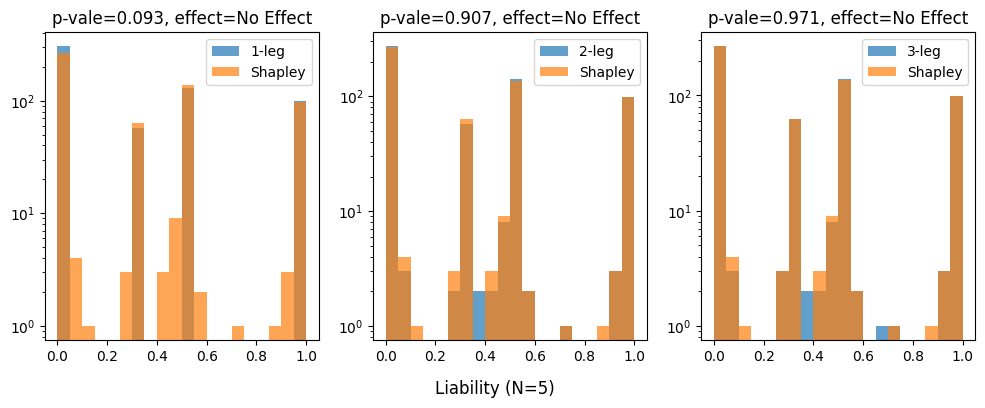

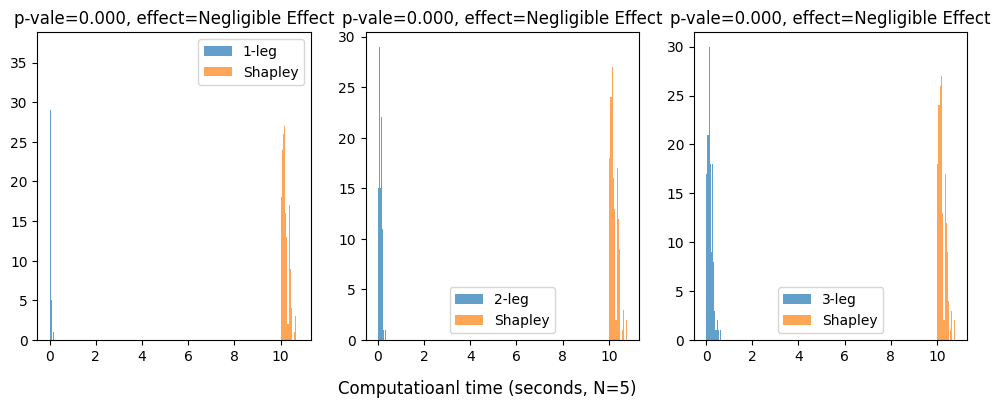

In [34]:
exp_results = experiment_and_plot(5, ks=[1,2,3], num_samples=200)

Doing experiments (num_samples=100) ...


100%|██████████| 100/100 [00:01<00:00, 64.17it/s]


Processing results for k in [1, 2, 3] ...


100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


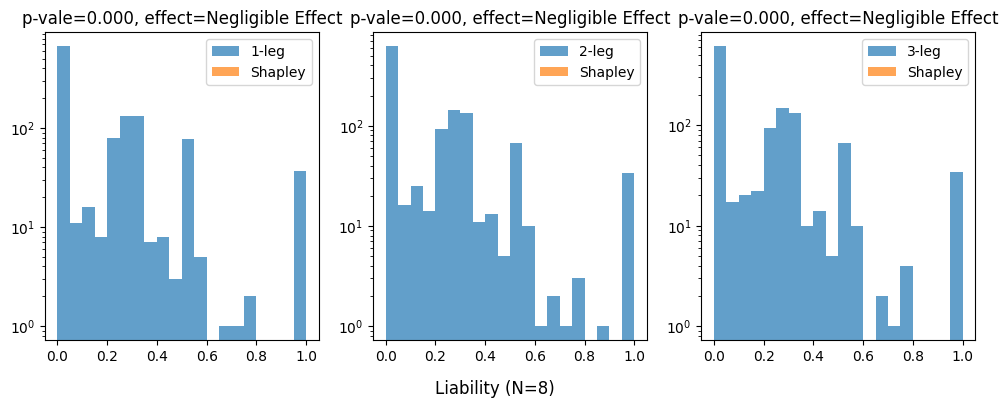

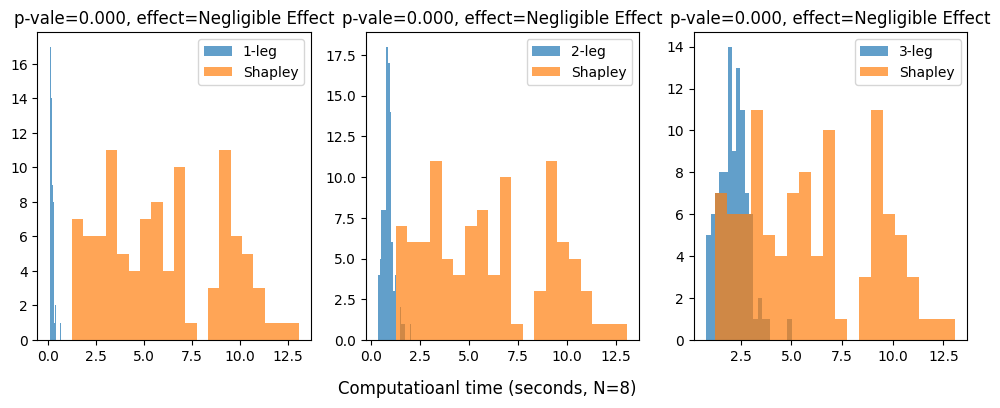

In [25]:
exp_results = experiment_and_plot(8, ks=[1,2,3], num_samples=100)

In [13]:
# diffs = []
# for i in range(1000):
#     S = get_random_system(num_vars, bool, seed=SEED)
#     T = rerand_system(S, seed=SEED+1)
#     M = S.induced_scm()
#     N = T.induced_scm()
#     vars = list(M.U) + list(M.V)
#     for var in vars:
#         locals()[var] = sp.symbols(var)
#     F = QFFOFormulaFailureSet(eval(get_rand_prop(vars, num_syms=1)))

#     for u_vals in all_combs_b(len(M.U)):
#         u = dict(zip([str(u) for u in M.U], u_vals))
#         state_m, _ = M.get_state(u)
#         state_n, _ = N.get_state(u)
#         if F.contains(state_m) or not F.contains(state_n):
#             # print('Specification already failed or implementation not failed or both!')
#             continue
#         print(k)
#         for k in range(1, 3):
#             k_leg = k_leg_liab(T, S, u, F, k=k)
#             shapley = shapley_liab(T, S, u, F, k=k)
#             for var in k_leg:
#                 if var in shapley:
#                     diffs.append(k_leg[var] - shapley[var])
#                 else:
#                     print(f'Warning: {var} not found in Shapley liability')
#         print()
    
# #############
# ## Current problem: generating a context that M[u] \notin F but N[u] \in F
# ## Solution: Use an SMT solver
# #############